## Task: Predict Food Delivery Time

You are provided with a food delivery dataset that includes features such as delivery distance, restaurant preparation time, traffic conditions, and order details. Your objective is to develop a regression model that accurately predicts the delivery time in minutes.

Your target is the column: "delivery_time".

You are provided with the code to download and load the csv file.

Your work will be evaluated based on the completion of the following tasks:


# Part 1: Read Data

**Tasks:**

1. Read the dataset `Q1_data.csv` using `read_csv()`
2. Inspect the first few rows using `head()`
3. Display dataset information using `info()`
4. Show statistical description using `describe()`
5. Plot the target distribution (delivery_time)

In [58]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Download latest version
path = kagglehub.dataset_download("mohammad2012191/q1-ka-ai-2026")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'q1-ka-ai-2026' dataset.
Path to dataset files: /kaggle/input/q1-ka-ai-2026


In [4]:
# Task 1: Write your code here:

df=pd.read_csv(f"{path}/Q1_data.csv")

In [5]:
# Task 2: Write your code here:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43.0
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84.0
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59.0
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37.0
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68.0


In [17]:
# Task 3: Write your code here:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1663 non-null   int64  
 1   Distance_km             1663 non-null   float64
 2   Weather                 1608 non-null   object 
 3   Traffic_Level           1612 non-null   object 
 4   Time_of_Day             1613 non-null   object 
 5   Vehicle_Type            1663 non-null   object 
 6   Preparation_Time_min    1663 non-null   int64  
 7   Courier_Experience_yrs  1614 non-null   float64
 8   Delivery_Time           1557 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 117.1+ KB


In [7]:
# Task 4: Write your code here:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time
count,1663.000000,1663.000000,1663.000000,1614.000000,1557.000000
mean,495.866506,10.049910,17.038485,4.586741,56.640976
std,289.514088,5.684406,7.230498,2.916843,22.135919
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,246.500000,5.130000,11.000000,2.000000,41.000000
50%,490.000000,10.160000,17.000000,5.000000,55.000000
75%,745.500000,14.980000,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


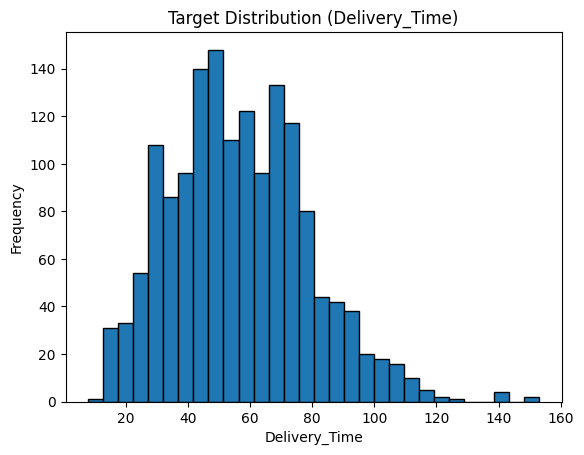

In [10]:
# Task 5: Write your code here:
def check_target_distribution(df, target_column):
  df[target_column].hist(bins=30, edgecolor='black')

  plt.title(f"Target Distribution ({target_column})")
  plt.xlabel(target_column)
  plt.ylabel("Frequency")
  plt.grid(False)

  plt.show()

check_target_distribution(df, "Delivery_Time")


# Part 2: Data Cleaning

**Tasks:**

Inspect and fix the following when needed:

1. **Drop the 'Order_ID' column from the data**
2. **Handle missing values appropriately** (Hint: I guess you want to have a closer look at the columns with missing values :) )
3. **Check and remove duplicates** if any exist
4. **Encode categorical variables** if needed (Bonus if used One Hot Encoding)
5. **Apply feature scaling for all features** (Use StandardScaler)
6. **Check for target imbalance and state if it is imbalanced or not** (keep this cell empty if not needed)

In [23]:
# Task 1: Write your code here:
df_clean= df.drop(columns=['Order_ID'])
df_clean.isnull().sum()

,0
Distance_km,0
Weather,55
Traffic_Level,51
Time_of_Day,50
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,49
Delivery_Time,106


In [33]:
# Task 2: Write your code here:
print("Missing values:")
print(df_clean.isnull().sum()) #finding number of null values in each column
for col in ['Weather', 'Time_of_Day', 'Traffic_Level']:#making objective coloumn as unknown because these columns contirbute in the target predtiction
    df_clean[col] = df_clean[col].fillna('unknown')

df_clean['Courier_Experience_yrs']=df_clean['Courier_Experience_yrs'].fillna(0)
df_clean['Delivery_Time']=df_clean['Delivery_Time'].fillna(df['Delivery_Time'].mean()) # we cant loose data about the target so we replace it with mean of the target


Missing values:
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time             0
dtype: int64


In [22]:
# Task 3: Write your code here:
def check_duplicates(df):
  duplicates = df.duplicated().sum()
  print(f"Number of Duplicate Samples: {duplicates}")
  if duplicates > 0:
    print("Dropping Duplicates...")
    df.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
  else:
    print("No Duplicate Samples Found.")

check_duplicates(df_clean)

Number of Duplicate Samples: 557
Dropping Duplicates...
Duplicates Dropped.


In [39]:
# Task 4: Write your code here:
categorical_cols = df_clean.select_dtypes(include=["object"]).columns

for col in categorical_cols:
  le = LabelEncoder()
  df_clean[col] = le.fit_transform(df[col])
df_clean.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time
0,-0.373046,1.726215,-0.303780,-1.210487,1.358221,-0.697047,-1.159992,43.0
1,1.120963,-0.887666,0.937463,-0.265398,-0.922164,0.409710,-0.823918,84.0
2,-0.093250,-0.234196,-0.303780,1.624781,1.358221,1.516467,-1.159992,59.0
3,-0.459273,0.419274,0.937463,-1.210487,1.358221,-1.665460,-1.159992,37.0
4,1.580252,-0.887666,-0.303780,0.679691,-0.922164,-0.143669,0.184305,68.0


In [41]:
# Task 5: Write your code here:
numerical_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.drop("Delivery_Time")  # DON'T SCALE THE TARGET

scaler = StandardScaler()
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])
df_clean.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time
0,-0.373046,1.726215,-0.303780,-1.210487,1.358221,-0.697047,-1.159992,43.0
1,1.120963,-0.887666,0.937463,-0.265398,-0.922164,0.409710,-0.823918,84.0
2,-0.093250,-0.234196,-0.303780,1.624781,1.358221,1.516467,-1.159992,59.0
3,-0.459273,0.419274,0.937463,-1.210487,1.358221,-1.665460,-1.159992,37.0
4,1.580252,-0.887666,-0.303780,0.679691,-0.922164,-0.143669,0.184305,68.0


In [ ]:
# Task 6: Write your code here:

# Part 3: Modeling

**Tasks:**

1. Split the dataset into features (X) and target (y)
2. Use the correct split: **KFold** OR **StratifiedKFold**
3. Train a **RandomForest** model
4. Evaluate using **MAE (Mean Absolute Error) ONLY**
5. Print the averaged score across all folds

In [54]:
# Task 1: Write your code here:
X = df_clean.drop("Delivery_Time", axis=1).astype(float)  #spliting dataset into features X and target y
y = df_clean['Delivery_Time'].astype(float)


In [60]:
# Task 2,3,4,5: Write your code here:
n_splits=5
losses=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model=RandomForestRegressor(n_estimators=200)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):# k-fold makes each fold validation for an iteration
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  X_train, X_test = X.iloc[train_index], X.iloc[test_index] #each time loop iterate we have a new fold as validation
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train,y_train)
  y_pred= model.predict(X_test)


  mae = mean_absolute_error(y_test, y_pred)
  losses.append(mae)


avg_loss=np.mean(losses) # caluclating avg loss across the fold

print(avg_loss)




Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5
6.0629097904576525


# Part 4: Plots

**Tasks:**

1. Plot feature importance from your trained model
2. Plot predicted delivery time histogram

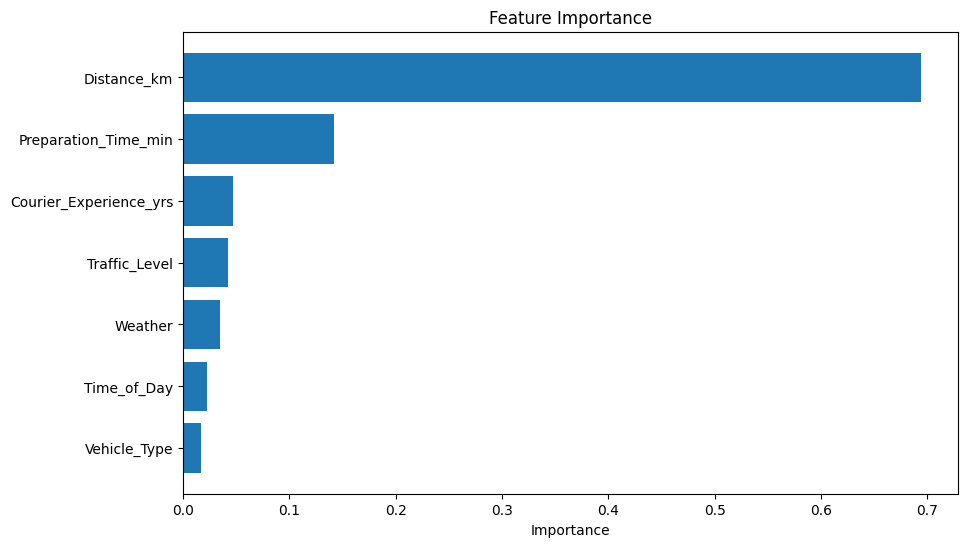

In [64]:
# Task 1: Write your code here:
feature_cols=['Distance_km', 'Weather', 'Traffic_Level','Time_of_Day','Vehicle_Type','Preparation_Time_min','Courier_Experience_yrs']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


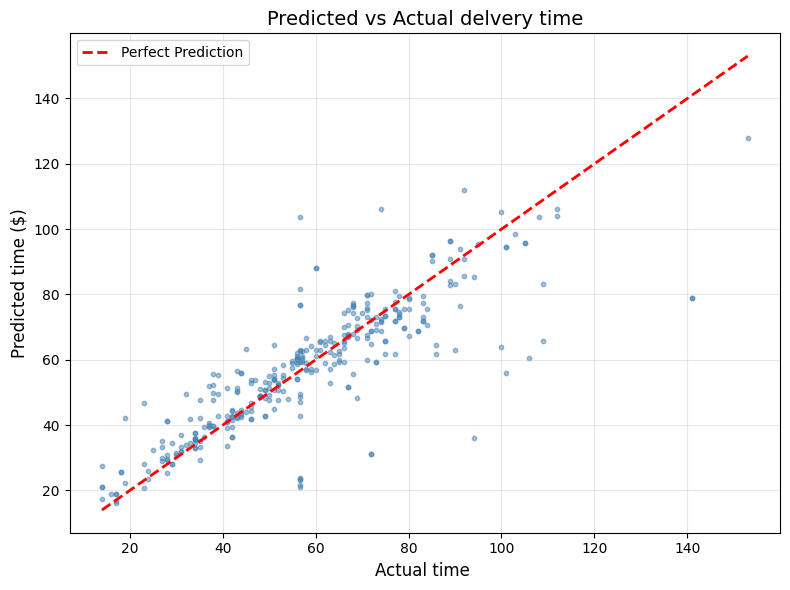

In [62]:
# Task 2: Write your code here:
# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))

# Plot: Predicted vs Actual scatter
plt.scatter(y_test, y_pred.flatten(), alpha=0.5, s=10, c='steelblue')

# Add perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual time ', fontsize=12)
plt.ylabel('Predicted time ($)', fontsize=12)
plt.title('Predicted vs Actual delvery time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Part 5: Bonus - Ensemble

**Task:**

Why use one model? Let's use 2 then merge!

Rewrite the KFold loop such that you:
1. Train **2 different models** inside the loop at the same time in each iteration
2. Average their predictions
3. Calculate the MAE metric on the averaged predictions

Use RandomForestRegressor and CatBoostRegressor.

In [ ]:
# Task Bonus: Write your code here:
